# <font>Project 10: "Variational Inference : A Review for Statisticians"</font>
#### <font>Team 7: Jean-Baptiste BAITAIRIAN, Ahmath GADJI, Vincent MONGKHOUN</font>


In [45]:
# Required packages
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from scipy.stats import multivariate_normal
from IPython.display import HTML
from matplotlib import animation, rc
import warnings
from sklearn.metrics.cluster import adjusted_rand_score

Mixture of Gaussian distributions

We follow the example in the article "Variational Inference: A Review for Statisticians" (Blei et al, 2017) and we consider a Bayesian mixture of unit-variance multivariate Gaussians. 

1. There are $K$ mixture components with means $\mu = \{\mu_1, \cdots, \mu_K \}$, each component $k$ of the mixture is a Gaussian distribution with mean $\mu_k$ and covariance matrix $I_d$. 

$$x|\mu_k \sim p(x|\mu_k) = \mathcal{N}(\mu_k, I_d)$$

2. The clusters' mean are random variables $\mu = (\mu_k)_{1\leqslant k \leqslant K}$ assumed to be independent and identically distributed (i.i.d.) with Gaussian distribution with mean 0 and variance $\Sigma$.

$$\mu_k \sim \mathcal{N}(0, \Sigma)\$$

3. To generate a data point $x_i$, we first have to identify its cluster. To do so, we use an assignment variable $c$ that indicates which latent cluster $k$ to draw from. In this model, all clusters have the same chance ($1/K$) to be chosen to draw a data point, so $c$ is the following categorical variable:

$$c \sim categorical (1/K, \cdots, 1/K)$$


From that, data points $(x_i)_{1 \leq i \leq n}$ are supposed to be generated following the generative history:

\begin{align*}
\mu_k &\sim \mathcal{N}(0, \Sigma) && \text{$k = 1 \cdots K$}\\
c_i &\sim categorical (1/K, \cdots, 1/K) && \text{$i = 1 \cdots n$}\\
x_i|c_i, \mu &\sim p(x|\mu_{c_i}) = \mathcal{N}(\mu_{c_i}, I_d)  && \text{$i = 1 \cdots n$}\\
\end{align*}



For a sample of size $n$, the joint density of latent and observed variables is: 

$$p(\mu, c, x) = p(\mu) \prod_{i=1}^{n} p(c_i)p(x_i|c_i, \mu)$$

The evidence is then
$$
p(x) = p(x_1,\cdots,x_n) = \int p(\mu) \prod_{i=1}^{n} \sum_{c_i} p(c_i)p(x_i|c_i, \mu) d\mu
$$

**Application** with $K= 5$, $\Sigma = \begin{bmatrix}
10 & 8\\
8 & 10
\end{bmatrix}$, $p(c_i = k) = 1/K$ for all $1\leqslant k \leqslant K$.

We generate $n=2000$ samples for the experiment. Moreover, data points have dimension $dim = 2$. 

In [46]:
# Sample data
np.random.seed(2) # Seed to ensure reproducibility
dim = 2
K = 5 # Number of mixture components
sigma2 = np.array([[10,8], # Covariance matrix for the means of the clusters (each mean has the same covariance matrix)
                   [8,10]])

In [47]:
mu = np.random.multivariate_normal([0,0], sigma2, K) # Means of the distribution in each cluster
n_samples = 2000 # Number of samples

In [48]:
mu

array([[ 1.30654037,  1.19400671],
       [ 4.76831748,  8.0488591 ],
       [ 6.22205412,  4.53855939],
       [-0.26335616, -2.75393234],
       [ 4.08286427,  2.26484904]])

In [49]:
idx = np.random.randint(0, K, n_samples) # The equivalent of c_i in the paper. It's the index of x_i's cluster. Array of size n_samples
# mu[idx] is the mean of the cluster in which each x_i is (it is an array)
X = np.random.normal(0, 1, size=(n_samples, dim)) + mu[idx] # We draw each x_i according to a Gaussian law with mean mu[idx][i] and variance 1. Array of size n_samples * dim

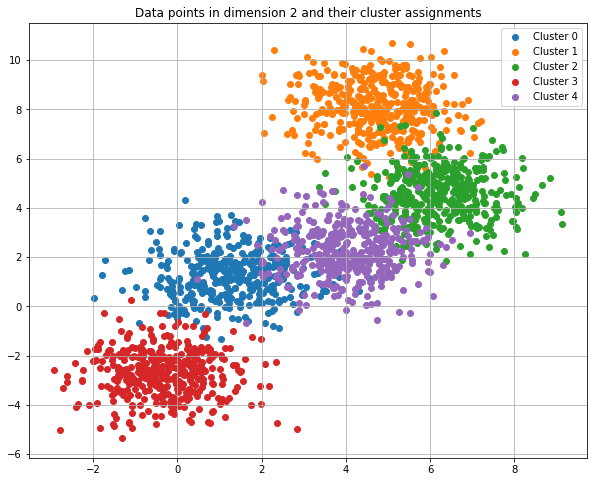

In [50]:
plt.figure(figsize=(10,8))
plt.grid(True)
for i in range(K):
    plt.scatter(X[idx == i, 0], X[idx == i,1], label=f"Cluster {i}")
    
plt.title("Data points in dimension 2 and their cluster assignments")
plt.legend()


Our aim is to approximate the posterior distribution $p(\mu,c|x)$ where $c = (c_1,\cdots,c_n)$ are the mixture components of the observations. 
In a generic form, we want to compute the posterior $p(z|x) = \frac{p(x, z)}{p(x)}$. In general, we can't compute the evidence $p(x) = \int p(x,z) dz$ in a reasonnable time. For example, in the case of bayesian mixture model, $p(x)$ has the following complicated form with an exponential complexity ($\mathcal{O}(K^n)$). 
$$
p(x) = \int p(\mu) \prod_{i=1}^{n} \sum_{c_i} p(c_i) P(x_i|c_i, \mu) d\mu
$$

# <font color=darkcyan> The idea behind Variational Inference </font>

Because of this intractable integral, we use variational methods to approach the posterior.

In variational inference, 
the idea is to pick a family of possible candidates distributions over the latent variable $Q$. Each element $q(z)$ in that family is a candidate that approximates the posterior and our goal is to find the best one $q^*$ in that family which is the one that minimizes the $KL$ (Kullback-Leibler) divergence to the exact posterior. 

$$
q^* =  \arg \min_{q \in \mathcal{Q}} \mathrm{KL}\left(q(z)\|p(z|x)\right)\,.
$$

Note that
\begin{align*}
\mathrm{KL}\left(q(\mu,c)\|p(\mu,c|x)\right) &= \mathbb{E}_q[\log q(\mu,c)] - \mathbb{E}_q[\log p(\mu,c|x)]\,,\\
 &= \mathbb{E}_q[\log q(\mu,c)] - \mathbb{E}_q[\log p(\mu,c,x)]+\log p(x)\,,\\
&= -\mathrm{ELBO}(q)+\log p(x)\,,
\end{align*}

where the Evidence Lower Bound (ELBO) is

$$
\mathrm{ELBO}(q) = -\mathbb{E}_q[\log q(\mu,c)] + \mathbb{E}_q[\log p(\mu,c,x)] \,.
$$

* Therefore, minimizing the KL divergence amounts to maximizing the ELBO, where $\log p(x)\geqslant \mathrm{ELBO}(q)$.

* The complexity of the family $\mathcal{Q}$ determines the complexity of the optimization.


## <font color=darkred> Proof of the update equation of the variational distribution with CAVI for the Mean-field family</font>

### <font color=darkred>**Mean field family**</font>

In this section, we focus on the mean-field variational family, where the latent variables are mutually independent and each governed by a distinct factor in the variational density. 
A member of this family is like the following

\begin{align*}
\mathrm{q}(z)&= \prod_{j=1}^{m} q_j(z_j) && \text{where m is the dimension of the hidden variable $z$ and $z_j \sim q_j(z_j)$.}
\end{align*}

### <font color=darkred>CAVI algorithm</font>


One of the most commonly used algorithms for solving this optimization problem is **CAVI** (Coordinate Ascent Variational Inference (Bishop, 2006)). CAVI iteratively optimizes each factor of the mean-field variational density, while
holding the others fixed.
    
- Fixing all $(q_m)_{m \neq j} $ except $q_j$, we optimize the ELBO over $q_j$. Then the $\mathrm{ELBO}$ is as the following:


\begin{align*}
\mathrm{ELBO}(q) &= \mathrm{ELBO}(q_j)\\ 
&=  \mathbb{E}_q \left[ \log p(z_j| x, z_{-j}) + \log p( x, z_{-j}) - \sum_{k=1}^{m} \log q_j(z_j) \right]\\ 
&= \mathbb{E}_{q_j} \left[ 
  \mathbb{E}_{X, Z_{-j}} \left[ \log p(z_j| x, z_{-j}) + \log p( x, z_{-j}) - \sum_{k=1}^{m} \log q_j(z_j) | z_j \right] \right]\\
&= \mathbb{E}_{q_j} \left[ 
  \mathbb{E}_{X, Z_{-j}} \left[ \log p(z_j| x, z_{-j}) - \log q_j(z_j) | z_j \right] \right] + cst\\
&= \mathbb{E}_{q_j} \left[  \mathbb{E}_{X, Z_{-j}} \left[ F \left(q_j(z_j) , \log p(z_j| x, z_{-j}) \right) | z_j \right] \right] + cst
\end{align*}


but $\arg \max_{q_j} \mathbb{E}_{q}[ \cdots ] \Leftrightarrow \arg \max_{q_j} \mathbb{E}_{X, Z_{-j}} \left[ F \left(q_j(z_j) , \log p(z_j| x, z_{-j}) \right) | z_j \right]  \text{for each $z_j$}$ 


So the maximizer $q^*_{j}$ verifies
\begin{align*}
q^*_{j}(z_j) &= \arg \max {E}_{X, Z_{-j}} \left[ f(q_j(z_j) , \log p(z_j| x, z_{-j})) | z_j \right])\,\\ 
&= \arg \max {E}_{X, Z_{-j}} \left[ -  \log q_j(z_j) +  \log p(z_j| x, z_{-j}) \right]\,\\ 
&= -  \log q_j(z_j) + {E}_{X, Z_{-j}} \left[ \log p(z_j| x, z_{-j})\right] + cst 
\end{align*}

So, $q^*_{j}(z_j)$ verifies the following equations:

$$\frac{-\partial \log q^*_j(z_j)}{\partial q_j(z_j)} + \frac{\partial {E}_{X, Z_{-j}} \left[ \log p(z_j| x, z_{-j})\right] }{\partial q_j(z_j)} = 0$$ 

$$\frac{\partial \log q^*_j(z_j)}{\partial z_j} = \frac{\partial {E}_{X, Z_{-j}} \left[ \log p(z_j| x, z_{-j})\right] }{\partial z_j}$$ 


<a id='cell1'></a>
Finally, 
$$ \boxed{q^*_j(z_j) \propto \exp ({E}_{X, Z_{-j}} \left[ \log p(z_j| x, z_{-j})\right])} \quad (1)$$ 

# <font color=darkcyan> Application to the mixture of Gaussians</font>

Our aim is to approximate the posterior distribution $p(\mu,c|x)$ where $c = (c_1,\cdots,c_n)$ are the mixture components of the observations.  The mean-field variational family is described as follows:

$$
q(\mu,c) = \prod_{k=1}^K \varphi_{m_k,\Sigma_k}(\mu_k)\prod_{i=1}^n \mathrm{cat}_{\phi_i}(c_i)\,, 
$$

which means that:

- $\mu$ and $c$ are independent.
- $(\mu_{k})_{1\leqslant k \leqslant K}$ are independent with Gaussian distribution with means $(m_{k})_{1\leqslant k \leqslant K}$ and covariances $(\Sigma _{k})_{1\leqslant k \leqslant K}$.



- $(c_{i})_{1\leqslant i \leqslant n}$ are independent with multinomial distribution with parameters $(\phi_i)_{1\leqslant i \leqslant n}$: $q(c_i=k) = \phi_i(k)$ for $1\leqslant k \leqslant K$. 

The family of such distributions is parameterized by $(m_{k})_{1\leqslant k \leqslant K}\in \mathbb{R}^{d \times K}$, the covariance matrices $(\Sigma_{k})_{1\leqslant k \leqslant K}\in (\mathbb{S_d(R)}_+)^K$ (real symmetric positive definite matrices) and $(\phi_i)_{1\leqslant i \leqslant n}\in \mathcal{S}_K^n$ where $\mathcal{S}_K$ is the $K$-dimensional probability simplex. 

### <font color=darkred> Update of $(\phi_i)_{1\leqslant i \leqslant n}$ using CAVI</font>

We apply the update [formula](#cell1) of the variational distribution to our mixture of Gaussian distribution model.

We then have:
\begin{align*}
q^*_i(c_i) &\propto \exp ({E}_{-c_j} \left[ \log p(c_j| x,\mu, c_{-j})\right]) \\
&\propto \exp ({E}_{-c_j} \left[ \log p(c_j, x,\mu, c_{-j})\right])
\end{align*}

* Under $-c_i$ (all variables except $c_j$), we can reduce the factor $p(c_j, x, \mu, c_{-j})$ and only keep the factors that depend on $c_i$:

\begin{align*}
p(\mu,c,x) &= p(\mu) \prod_{i=1}^n p(x_i|\mu) p(c_i) 
= \prod_{k=1}^Kp(\mu_k) \prod_{i=1}^n  p(c_i) \prod_{k=1}^K p(x_i|\mu_k)^{\mathbb{1}_{c_i = k}}
  \\
  &\propto p(c_i) \prod_{k=1}^K p(x_i|\mu_k)^{\mathbb{1}_{c_i = k}} && \text{Other terms don't depend on ci so we can get rid of them.} 
\end{align*}

Then,
\begin{align*}
q^*_i(c_i = k) & \propto p(c_i = k) \exp (p(c_i = k) \exp ({E}_{\mu_k \sim \mathcal{N}(m_k,\Sigma_k)} \left[ \log p(x_i | \mu_k) \right]) && \text{with $x_i | \mu_k \sim \mathcal{N}(\mu_k, {I}_d)$}\\
&\propto p(c_i = k) \exp ( {E}_{\mu_k \sim \mathcal{N}(m_k,\Sigma_k)} \left[x_i^T.\mu_k - \frac{||\mu_k||_2^2}{2} \right]) \\
q^*_i(c_i = k) &\propto p(c_i = k) \exp (x_i^T.m_k - \frac{m_k^Tm_k + {tr}(\Sigma_{k}) }{2})
\end{align*}

Finally,
$$\boxed{\phi_i(k) \propto p(c_i = k) \exp (x_i^T.m_k - \frac{m_k^Tm_k + {tr}(\Sigma_{k}) }{2}) }$$

In [51]:
# Function to update phi in CAVI algorithm
def CAVI_update_phi(X, m, s2):
    """
    :param X: our data points
    :param m: estimated mean in the law q
    :param s2: estimated variance in the law q
    :return: the updated phi
    """
    
    first_term = X @ m.T

    second_term = - (np.linalg.norm(m, axis=1)**2 + s2.trace(axis1=-2, axis2=-1)) / 2
    second_term = second_term.reshape(1, -1)
    x = first_term + second_term
    x = x - x.max(axis=1, keepdims=True) ## avoid pb of overflow

    phi = np.exp(x)
    phi = phi / phi.sum(1, keepdims=True)
    
    return phi

### <font color=darkred> Update of $(m_k)_{1\leqslant k \leqslant K}$ and $(\Sigma_k)_{1\leqslant k \leqslant K}$ using CAVI</font>

\begin{align*}
q^*_k(\mu_k) &\propto \exp ({E}_{-\mu_k} \left[ \log p(\mu_k| x, c, \mu_{-k})\right]) \\
&\propto \exp ({E}_{-\mu_k} \left[ \log p(\mu_k, \mu_{-j}, x, c)\right])\\
&\propto \exp ({E}_{-\mu_k} \left[ \log p(\mu, x, c) \right])\\
\end{align*}

With 

\begin{align*}
p(\mu,c,x) &= p(\mu) \prod_{i=1}^n p(x_i|\mu) p(c_i)\ 
= \prod_{k=1}^Kp(\mu_k) \prod_{i=1}^n  p(c_i) \prod_{k=1}^K p(x_i|\mu_k)^{\mathbb{1}_{c_i = k}}\\
&\propto p(\mu_k) \prod_{i=1}^n p(x_i|\mu_k)^{\mathbb{1}_{c_i = k}}  && \text{Other terms don't depend on $\mu_k$ so we can get rid of them.} 
\end{align*}

\begin{align*}
\log p(\mu,c,x) &=  \log p(\mu_k) + \sum_{i=1}^n \mathbb{1}_{c_i = k} \log p(x_i|\mu_k) + cst \\
&= - \frac{\mu_k^T \Sigma^{-1}\mu_k}{2} + \sum_{i=1}^n \mathbb{1}_{c_i = k} \left[ x_i^Tm_k - \frac{||\mu_k||_2^2}{2} \right] + cst \\
{E}_{-\mu_k}\left[ \log p(\mu,c,x) \right] &= - \frac{\mu_k^T \Sigma^{-1}\mu_k}{2} + \sum_{i=1}^n \phi_i(k) \left( x_i^T\mu_k - \frac{\mu_k^T\mu_k}{2} \right) + cst \\
& = \mu_k^T \left(\sum_{i=1}^n \phi_i(k)x_i \right) -\frac{1}{2}\mu_k^T \left( \Sigma^{-1} + \sum_{i=1}^n \phi_i(k) {I}_d \right) \mu_k + cst
\end{align*}

Since
$
q^*_k(\mu_k) \propto \exp ({E}_{-\mu_k} \left[ \log p(\mu, x, c) \right])$ and $\mu_k \sim \mathcal{N}(m_k,\Sigma_k)$.
then we can identify the mean and the variance of the distribution which gives the following update equations for CAVI:

$$
\Sigma_{k}^{-1} = \Sigma^{-1} + \sum_{i=1}^n \phi_i(k)I_{m}
\quad\mathrm{and}\quad m_k = \Sigma_{k}(\sum_{i=1}^n \phi_i(k)x_i)
$$

In [52]:
## Function to update sigma_k and m_k
def CAVI_update_mu_s2(X, phi, sigma2, K, dim):
    """
    :param X: our data points
    :param phi: estimated phi in the law q
    :param sigma2: covariance matrix of the means of the clusters
    :param K: number of clusters
    :param dim: number of dimensions of the problem
    :return: the updated m and s2
    """

    p = phi.T.sum(axis=1, keepdims=True)
    s2_inv = np.linalg.inv(sigma2) + p.reshape(-1,1)[:,:,None] * np.identity(dim)
    s2 = np.linalg.inv(s2_inv)

    a = (phi.T @ X)
    m  = (s2 @ a[:,:,None])[:,:,0]
    return m, s2

### <font color=darkred>Computation of the $\mathrm{ELBO}$</font>

We have 
$
\mathrm{ELBO}(q) = \mathrm{ELBO}((m_k)_k, (\Sigma_k)_{k}, (\phi_i)_i)  = -\mathbb{E}_q[\log q(\mu,c)] + \mathbb{E}_q[\log p(\mu,c,x)] \,.
$

With
$\mu_k \sim \mathcal{N}(m_k,\Sigma_k)\$ and 

$
\varphi_{m_k,\Sigma_k}(\mu_k) = (2\pi)^{-d}  (\det(\Sigma_k)^{\frac{-1}{2}} \exp(-\frac{(\mu_k - m_k)^{T} Σ_k^{-1} (\mu_k - m_k)}{2})
$


$d$ being the feature dimension of our data.


1.  First of all we have:
\begin{align*}
q(\mu,c) &= \prod_{k=1}^K \varphi_{m_k,\Sigma_k}(\mu_k)\prod_{i=1}^n \mathrm{Cat}_{\phi_i}(c_i) 
  = \prod_{k=1}^K \varphi_{m_k,\Sigma_k}(\mu_k) \prod_{i=k}^n  \prod_{i=1}^K{\phi_i}(c_i = k)^{\mathbb{1}_{c_i = k}}\,,\\
\end{align*}

Same for $p(\mu,c,x)$, we have:

\begin{align*}
p(\mu,c,x) &= p(\mu) \prod_{i=1}^n p(x_i|\mu)
= \prod_{k=1}^Kp(\mu_k) \prod_{i=1}^n \prod_{k=1}^K p(x_i|\mu_k)^{\mathbb{1}_{c_i = k}}
  \\
\end{align*}


So, we have: 
\begin{align*}
\log q(\mu,c) &= \sum_{i=1}^n \sum_{k=1}^K \mathbb{1}_{c_i = k} \log({\phi_i}(k)) + \sum_{k=1}^K - \frac{\log(\det(\Sigma_k)}{2} - \frac{(\mu_k - m_k)^{T} Σ_k^{-1} (\mu_k - m_k)}{2} + \mathrm{cst}\,,\\ 
\end{align*}
and
\begin{align*}
\log p(x, \mu,c) &= \sum_{i=1}^n \sum_{k=1}^K  \mathbb{1}_{c_i = k} \left[- \frac{\log(\det(I))}{2} - \frac{(x_i - \mu_k)^{T} (x_i - \mu_k)}{2} \right] 
+ \sum_{k=1}^{K} -\frac{\log(\det (\Sigma))}{2} - \frac{\mu_k^{T}\Sigma^{-1}\mu_k}{2} + \mathrm{cst} \\ 
\end{align*}

2. Knowing that 
\begin{align*}
\mathbb{E}_{\mathcal{N}(m_k,\Sigma_k)} ((\mu_k - m_k)^{T} Σ_k^{-1} (\mu_k - m_k)
&= \mathbb{E}(\mathrm{Tr}(Σ_k^{-1} (\mu_k - m_k)(\mu_k - m_k)^{T})) \\ 
&= \mathrm{Tr}(Σ_k^{-1} \mathbb{E} ((\mu_k - m_k)(\mu_k - m_k)^{T} ))\\
&= \mathrm{Tr}(Σ_k^{-1} Σ_k) = d
\end{align*}
,
\begin{align*}
\mathbb{E} \left[ (x_i - \mu_k)^{T} (x_i - \mu_k) \right] &=  \mathbb{E} \left[ \mu_k^{T}\mu_k -2\mu_k^{T}x_i + x_i^{T}x_i \right]\,\\
&= \mathbb{E} \left[ \mu_k^{T}\mu_k \right] -2m_k^{T}x_i +\mathbb{cst}\,\\ 
&= m_k^{T}m_k + \mathrm{Tr}(\Sigma_k) -2m_k^{T}x_i + \mathbb{cst}
\end{align*}

and, finally,
\begin{align*}
\mathbb{E} \left[ \mu_k^{T}\Sigma^{-1}\mu_k \right] &= \mathbb{E} \left[ \mathrm{Tr} (\mu_k^{T}\Sigma^{-1}\mu_k) \right] \,\\ 
&= \mathbb{E} \left[ \mathrm{Tr} (\Sigma^{-1}\mu_k \mu_k^{T}) \right] \,\\ 
&= \mathrm{Tr} ( \Sigma^{-1} \mathbb{E} (\mu_k \mu_k^{T}) \left[  \right])\,\\ 
&= \mathrm{Tr} ( \Sigma^{-1} (m_k m_k^{T} + \Sigma_{k}))\,\\
&=  m_k\Sigma^{-1}m_k^{T} + \mathrm{Tr} (\Sigma^{-1} \Sigma_{k})
\end{align*}

We have 
\begin{align*}
\mathrm{ELBO}(q) &= \mathrm{ELBO}((m_k)_k, (\Sigma_k)_{k}, (\phi_i)_i)\,\\ 
&= \sum_{k=1}^{K}  \frac{\log(\det(\Sigma_k))}{2}  - \frac{m_k\Sigma^{-1}m_k^{T} + \mathrm{Tr} (\Sigma^{-1} \Sigma_{k})}{2} \,\\
&+ \sum_{i=1}^n \sum_{k=1}^K - \phi_i(k) \log(\phi_i(k)) - \phi_i(k) (\frac{m_k^{T}m_k + \mathrm{Tr}(\Sigma_k) -2m_k^{T}x_i}{2})\,\\ 
&= \sum_{k=1}^{K}  \frac{\log(\det(\Sigma_k))}{2}  - \frac{m_k\Sigma^{-1}m_k^{T} + \mathrm{Tr} (\Sigma^{-1} \Sigma_{k})}{2}
+ \sum_{i=1}^n \sum_{k=1}^K \phi_i(k) \left[ m_k^{T}x_i - \log(\phi_i(k)) - \frac{m_k^{T}m_k + \mathrm{Tr}(\Sigma_k)}{2}\right]
\end{align*}

In [53]:
## Function to calculate the ELBO
def elbo(X, phi, m, s2, sigma2):
    eps = 1e-8
    phi = phi + eps
    t1 = np.linalg.det(s2)
    t1 = t1 - (m[:,None,:] @ np.linalg.inv(sigma2)@m[:,:,None]).flatten()  - (np.linalg.inv(sigma2) @ s2).trace(axis1=-2, axis2=-1)
    t1 = t1.sum()/2

    second_term = -(np.linalg.norm(m, axis=1)**2 + s2.trace(axis1=-2, axis2=-1))/2
    second_term = second_term.reshape(1,-1)
    second_term = (X @ m.T - np.log(phi)) + second_term
    second_term = second_term*phi
    t2 = second_term.sum()
    return t1 + t2

In the next cell we have the code of the CAVI algorithm for the Gaussian mixture model. We have chosen to stop the algorithm when the $ELBO$ doesn't move anymore meaning that:
$$|ELBO_{t+1} - ELBO_{t}| \leq \epsilon, \forall t \geq 0 $$  with $\epsilon = 10^{-2}$

In [54]:
## Function to apply CAVI to a Gaussian mixture
def CAVI_mixture_Gaussian(X, m, s2, phi, sigma2, max_iter = 500, epsilon = 1e-2):
    elbos  = [elbo(X, phi, m, s2, sigma2)]
    m_est  = [m]
    s2_est = [s2]
    phi_est = [phi]

    k, dim = phi.shape[1] , m.shape[1] 
    for it in range(1, max_iter + 1):
        phi = CAVI_update_phi(X, m, s2)
        m, s2 = CAVI_update_mu_s2(X, phi, sigma2, K, dim)
    
        m_est.append(m)
        s2_est.append(s2)
        phi_est.append(phi)

        elbos.append(elbo(X, phi, m, s2, sigma2))

        if np.abs(elbos[-2] - elbos[-1]) <= epsilon:
            break

    return elbos, m_est, s2_est, phi_est

In [55]:
## Initialization
phi_init = np.random.dirichlet([np.random.random() * np.random.randint(1, 10)] * K, n_samples)
m_init = np.random.normal(0, 10, (K, dim))
s2_init = np.random.normal(0, 10, (K, dim, dim))
sigma2_init = np.array([[1, 0],
                        [0, 1]])
print(phi_init.shape)
print(s2_init.shape)
print(m_init.shape)

(2000, 5)
(5, 2, 2)
(5, 2)


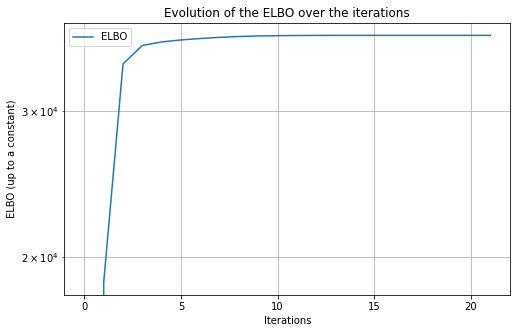

In [56]:
fig = plt.figure(figsize=(8, 5))
elbos, m_est, s2_est, phi_est = CAVI_mixture_Gaussian(X, m_init, s2_init, phi_init, sigma2_init)
plt.plot(np.array(elbos), label='ELBO')
plt.yscale('log')
plt.tick_params(labelright=True)
plt.grid(True, which="both")
plt.xlabel('Iterations')
plt.ylabel("ELBO (up to a constant)")
plt.title("Evolution of the ELBO over the iterations")
plt.legend();

In [57]:
m_est

[array([[ -5.78304577,  19.2257072 ],
        [ 16.41653579,   5.53732275],
        [ -6.98866674,  12.83936262],
        [-16.58082734,   0.07130149],
        [  0.48150565,  10.54185954]]),
 array([[ 2.15775101e-33,  9.75945473e-33],
        [ 7.71885531e+00,  3.72501374e+00],
        [-9.40256861e-18,  5.79717091e-18],
        [-1.99716597e+00, -3.76263113e+00],
        [ 3.16667741e+00,  2.74981206e+00]]),
 array([[ 0.51568525, -0.13789773],
        [ 5.92794021,  6.00099253],
        [ 0.51568525, -0.13789773],
        [-0.54000229, -3.09751497],
        [ 3.59320316,  3.4836516 ]]),
 array([[ 0.93890219,  0.49556529],
        [ 5.49809051,  6.63886431],
        [ 0.93890219,  0.49556529],
        [-0.41993625, -2.96232802],
        [ 4.10024539,  2.57464507]]),
 array([[ 1.10111988,  0.96419094],
        [ 5.37708058,  6.90470953],
        [ 1.10111988,  0.96419094],
        [-0.37547163, -2.8410691 ],
        [ 4.55672942,  2.62176328]]),
 array([[ 1.29756641,  1.18342374],
    

In [58]:
m_absc1 = [[row[0, 0]] for row in m_est] # Evolution of the abscissa of the mean of the first cluster over the iterations
m_absc2 = [[row[1, 0]] for row in m_est]
m_absc3 = [[row[2, 0]] for row in m_est]
m_absc4 = [[row[3, 0]] for row in m_est]
m_absc5 = [[row[4, 0]] for row in m_est]

m_ord1 = [[row[0, 1]] for row in m_est]
m_ord2 = [[row[1, 1]] for row in m_est]
m_ord3 = [[row[2, 1]] for row in m_est]
m_ord4 = [[row[3, 1]] for row in m_est]
m_ord5 = [[row[4, 1]] for row in m_est]

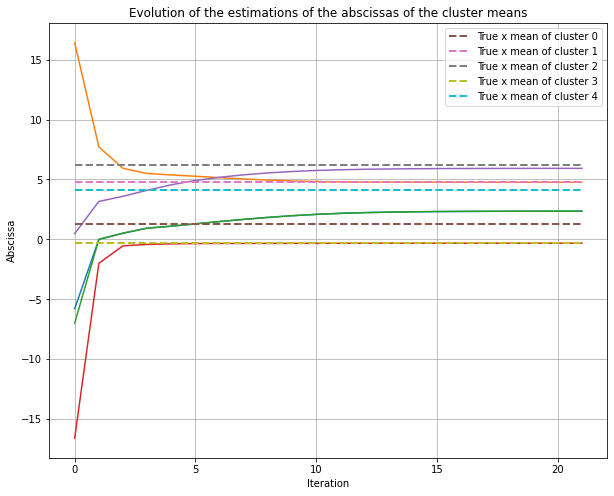

In [59]:
nb_iter_max = len(m_absc1)

plt.figure(figsize=(10, 8))
plt.plot(m_absc1)
plt.plot(m_absc2)
plt.plot(m_absc3)
plt.plot(m_absc4)
plt.plot(m_absc5)

plt.plot(np.arange(nb_iter_max),mu[0][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 0', ls='--')
plt.plot(np.arange(nb_iter_max),mu[1][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 1', ls='--')
plt.plot(np.arange(nb_iter_max),mu[2][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 2', ls='--')
plt.plot(np.arange(nb_iter_max),mu[3][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 3', ls='--')
plt.plot(np.arange(nb_iter_max),mu[4][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 4', ls='--')

plt.title("Evolution of the estimations of the abscissas of the cluster means")
plt.xlabel("Iteration")
plt.ylabel("Abscissa")
plt.grid(True)
plt.legend()

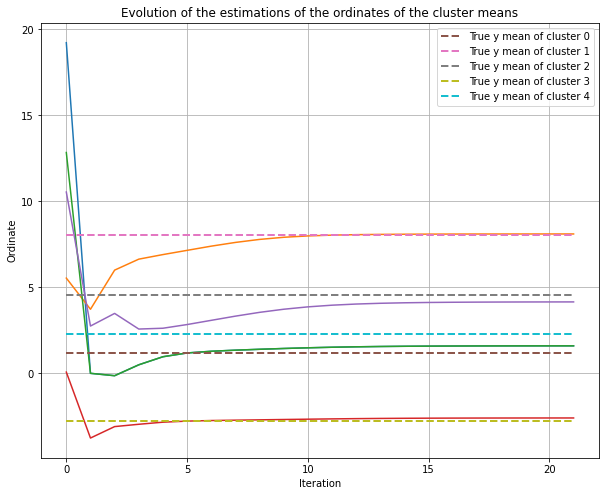

In [60]:
nb_iter_max = len(m_absc1)

plt.figure(figsize=(10, 8))
plt.plot(m_ord1)
plt.plot(m_ord2)
plt.plot(m_ord3)
plt.plot(m_ord4)
plt.plot(m_ord5)

plt.plot(np.arange(nb_iter_max),mu[0][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 0', ls='--')
plt.plot(np.arange(nb_iter_max),mu[1][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 1', ls='--')
plt.plot(np.arange(nb_iter_max),mu[2][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 2', ls='--')
plt.plot(np.arange(nb_iter_max),mu[3][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 3', ls='--')
plt.plot(np.arange(nb_iter_max),mu[4][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 4', ls='--')

plt.title("Evolution of the estimations of the ordinates of the cluster means")
plt.xlabel("Iteration")
plt.ylabel("Ordinate")
plt.grid(True)
plt.legend()

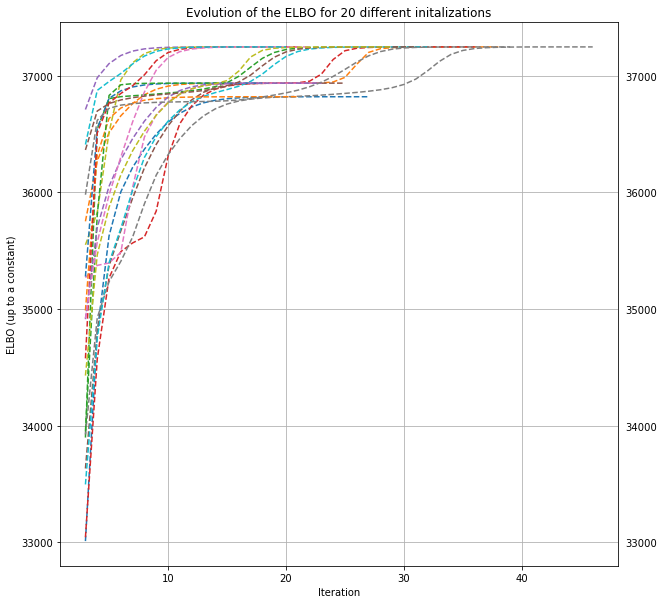

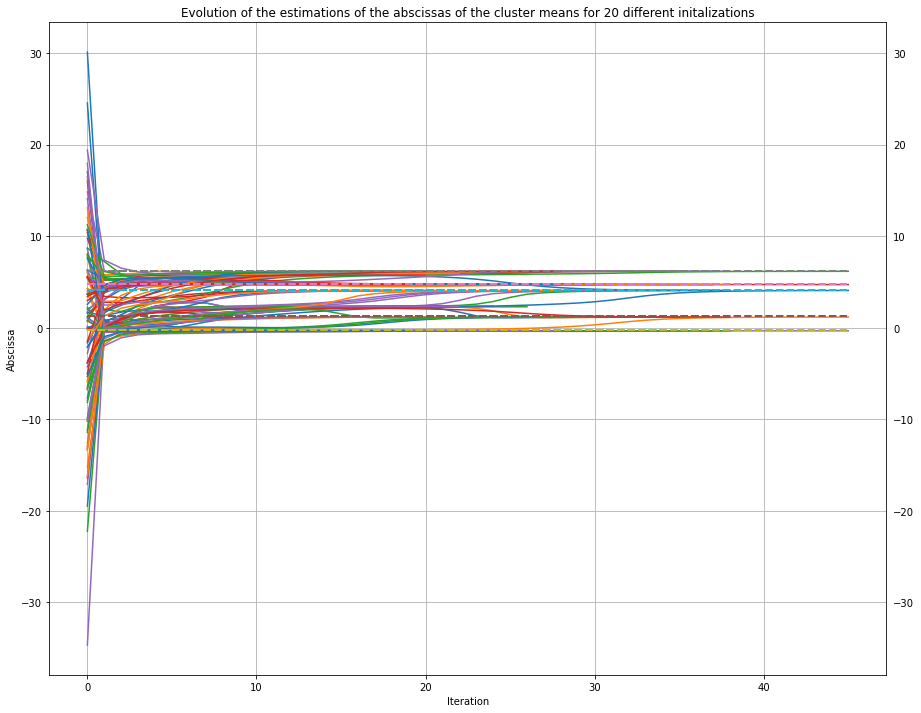

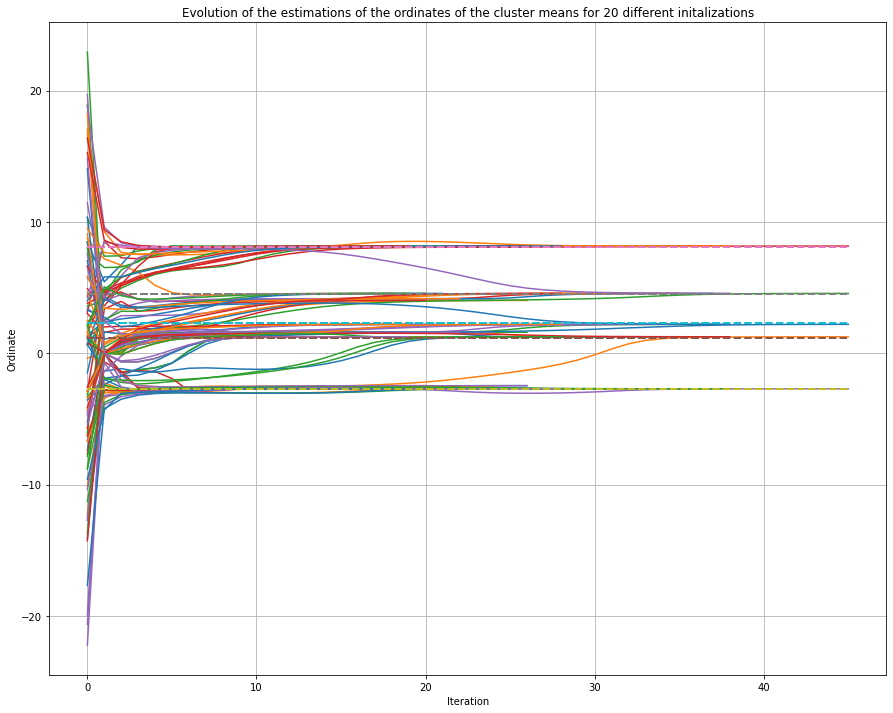

In [61]:
nb_iter_max = 0
nb_initialisations = 20
for _ in range(nb_initialisations): # We try 20 different initializations
    # Initialization
    phi_init = np.random.dirichlet([np.random.random() * np.random.randint(1, 10)] * K, n_samples)
    m_init = np.random.normal(0, 10, (K,dim))
    s2_init = np.random.normal(0, 10, (K, dim, dim))
    sigma2_init = np.array([[1, 0],
                            [0, 1]])
    elbos, m_est, s2_est, phi_est = CAVI_mixture_Gaussian(X, m_init, s2_init, phi_init, sigma2_init)
    
    nb_iter = np.array(elbos).size
    if nb_iter>nb_iter_max:
        nb_iter_max = nb_iter
    
    plt.figure(0, figsize=(10,10))
    plt.plot(np.arange(3, nb_iter+1), np.array(elbos[2:]), '--') # On commence à partir de la troisième valeur d'ELBO calculée pour éviter d'avoir des valeurs trop extrêmes au début
    plt.tick_params(labelright=True)
    plt.grid(True)
    plt.title("Evolution of the ELBO for {} different initalizations".format(nb_initialisations))
    plt.xlabel('Iteration')
    plt.ylabel('ELBO (up to a constant)')
    
    m_absc1 = [[row[0, 0]] for row in m_est] # Evolution of the abscissa of the mean of the first cluster over the iterations
    m_absc2 = [[row[1, 0]] for row in m_est]
    m_absc3 = [[row[2, 0]] for row in m_est]
    m_absc4 = [[row[3, 0]] for row in m_est]
    m_absc5 = [[row[4, 0]] for row in m_est]

    m_ord1 = [[row[0, 1]] for row in m_est]
    m_ord2 = [[row[1, 1]] for row in m_est]
    m_ord3 = [[row[2, 1]] for row in m_est]
    m_ord4 = [[row[3, 1]] for row in m_est]
    m_ord5 = [[row[4, 1]] for row in m_est]
    
    nb_iter_max = len(m_absc1)

    plt.figure(1, figsize=(15, 12))
    plt.plot(m_absc1)
    plt.plot(m_absc2)
    plt.plot(m_absc3)
    plt.plot(m_absc4)
    plt.plot(m_absc5)

    plt.plot(np.arange(nb_iter_max),mu[0][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 0', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[1][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 1', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[2][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 2', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[3][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 3', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[4][0]*np.ones(nb_iter_max), linewidth=2, label = 'True x mean of cluster 4', ls='--')

    plt.tick_params(labelright=True)
    plt.title("Evolution of the estimations of the abscissas of the cluster means for {} different initalizations".format(nb_initialisations))
    plt.xlabel("Iteration")
    plt.ylabel("Abscissa")
    plt.grid(True)
    
    nb_iter_max = len(m_absc1)

    plt.figure(2, figsize=(15, 12))
    plt.plot(m_ord1)
    plt.plot(m_ord2)
    plt.plot(m_ord3)
    plt.plot(m_ord4)
    plt.plot(m_ord5)

    plt.plot(np.arange(nb_iter_max),mu[0][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 0', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[1][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 1', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[2][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 2', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[3][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 3', ls='--')
    plt.plot(np.arange(nb_iter_max),mu[4][1]*np.ones(nb_iter_max), linewidth=2, label = 'True y mean of cluster 4', ls='--')

    plt.title("Evolution of the estimations of the ordinates of the cluster means for {} different initalizations".format(nb_initialisations))
    plt.xlabel("Iteration")
    plt.ylabel("Ordinate")
    plt.grid(True)

In [62]:
elbos

[-158471.865213443,
 29389.92788772779,
 36409.08735992324,
 36872.56327258637,
 36948.50058503561,
 37017.42948751979,
 37099.03789225238,
 37166.94801331401,
 37207.31626810964,
 37227.427624273165,
 37236.91430876465,
 37241.32846631687,
 37243.366639428954,
 37244.30197934503,
 37244.729419731084,
 37244.92427566967,
 37245.01299793915,
 37245.05338337499,
 37245.0717744416,
 37245.08015922993]

In [63]:
s2_est[-1]

array([[[0.00244953, 0.        ],
        [0.        , 0.00244953]],

       [[0.00253075, 0.        ],
        [0.        , 0.00253075]],

       [[0.00235069, 0.        ],
        [0.        , 0.00235069]],

       [[0.00245479, 0.        ],
        [0.        , 0.00245479]],

       [[0.00271116, 0.        ],
        [0.        , 0.00271116]]])

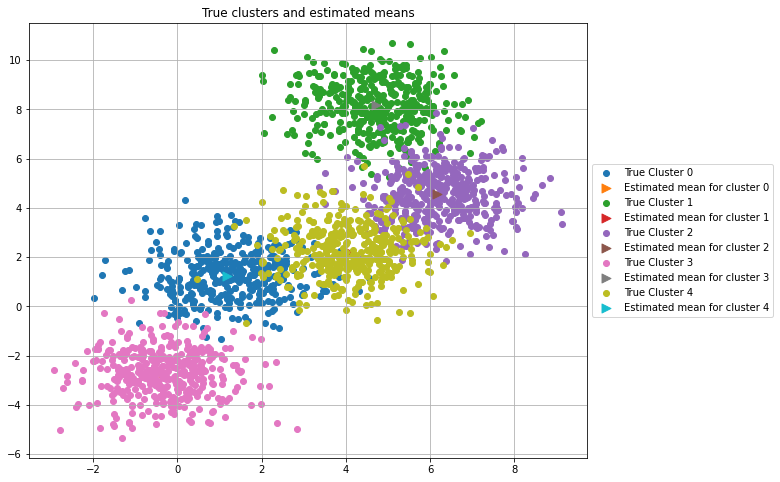

In [64]:
# Posterior distribution of the means in each group

plt.figure(figsize=(10, 8))
plt.grid(True)

for i in range(K):
    plt.scatter(X[idx == i, 0], X[idx == i,1], label=f"True Cluster {i}")
    plt.legend()
    cov, mean = s2_est[-1][i], m_est[-1][i,:] ## Latest value of the estimators
    plt.scatter(mean[0], mean[1], s=80, marker=">", label=f"Estimated mean for cluster {i}")

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.title("True clusters and estimated means")
plt.show()

It is normal to have small values in the estimator of the covariance matrix of the posterior distribution of the means (in the mean-field family) in each groupe.

- Once we have a fitted variational density, we can use it as we
would use the posterior. For example, we can obtain a posterior decomposition of the data. We assign points to their most likely mixture assignment
$c_i = \arg \underset{1 \leq k \leq K} \max  ϕ_i(k)$ and estimate cluster
means with their variational means $m_k$.

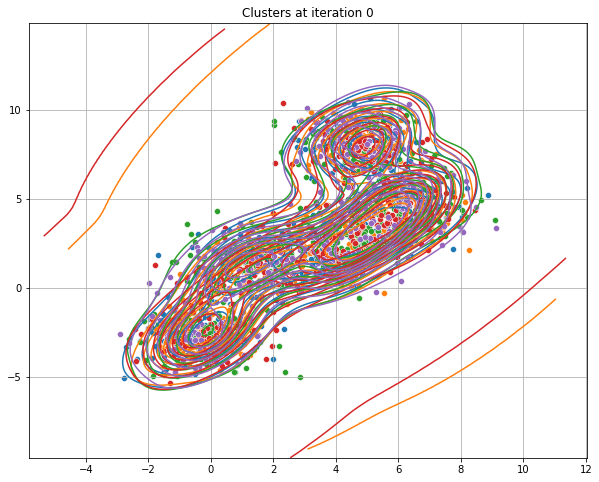

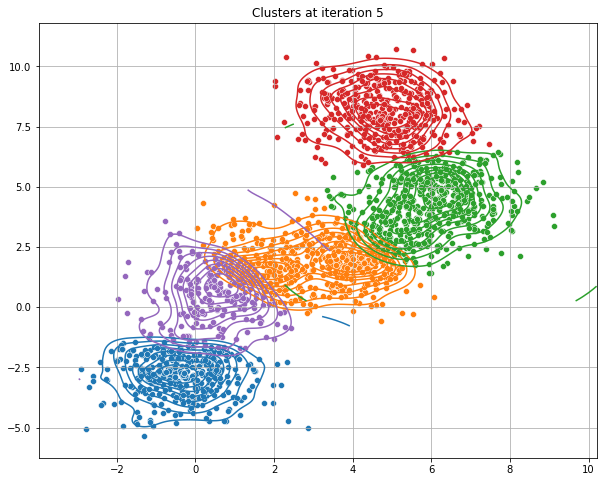

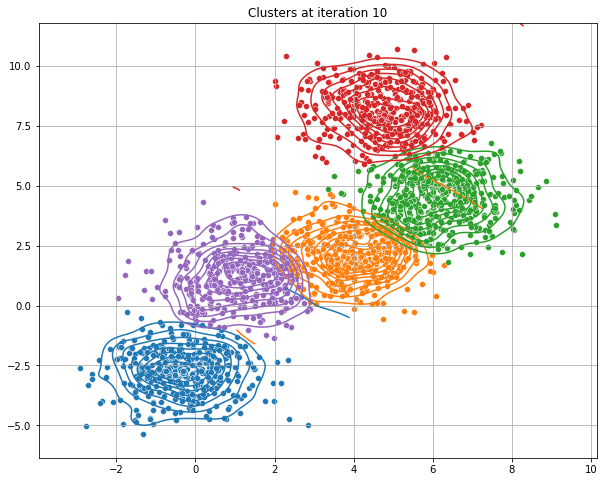

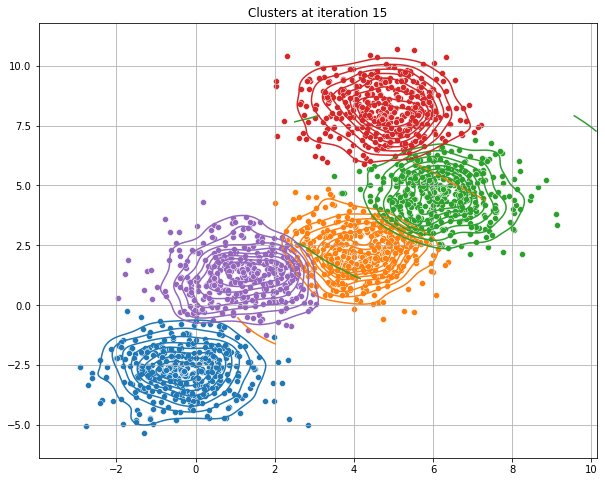

In [65]:
warnings.filterwarnings('ignore')

for j in range(0, len(phi_est)):
    
    if j%5 == 0  and j < 20:
        plt.figure(figsize=(10, 8))
        plt.grid(True)
        C = phi_est[j].argmax(axis=1)
        
        for i in list(set(C)):
            sns.kdeplot(X[C==i, 0], X[C==i, 1], thresh=0)
            sns.scatterplot(X[C == i, 0], X[C == i,1])
            plt.title(f"Clusters at iteration {j}")
            plt.plot()

In [66]:
fig, ax = plt.subplots(figsize=(10,8))
ax.grid()
plt.close()

def h(j):
    C = phi_est[j].argmax(axis=1)
    ax.scatter(X[:, 0], X[:,1], c=C)
    ax.set_title(f"Clusters at iteration {j}")

In [67]:
#plt.grid()
anim = animation.FuncAnimation(fig, h, len(phi_est), repeat = False, interval=5)
rc('animation', html='jshtml')
anim

The borders between between clusters seems to be linear. Actually, it is not surprising given that

\begin{align*}
c_i &= \arg \underset{1 \leq k \leq K} \max  ϕ_i(k)\\
& = \arg \underset{1 \leq k \leq K} \max \exp(x_i^T.m_k - \frac{m_k^Tm_k + {tr}(\Sigma_k)}{2})\\
&= \arg \underset{1 \leq k \leq K} \max \log \left( \exp \left(x_i^T.m_k - \frac{m_k^Tm_k + {tr}(\Sigma_k)}{2} \right) \right)\\
&= \arg \underset{1 \leq k \leq K} \max x_i^T.m_k - \frac{m_k^Tm_k + {tr}(\Sigma_k)}{2}\\
&= \arg \underset{1 \leq k \leq K} \max x_i^T.w_k + b_k && \text{$w_k = m_k$ and $b_k = - \frac{m_k^Tm_k + {tr}(\Sigma_k)}{2}$}
\end{align*}
We can see that the decision is linear in x which explains the observed borders of the clusters. 

In [68]:
## Get clusters and evaluate the quality of the clustering in average
C = phi_est[-1].argmax(axis=1)
score = adjusted_rand_score(labels_true=idx, labels_pred=C)
print(f"Quality of the clustering: {round(score, 3)}")

Quality of the clustering: 0.839


# <font color=darkcyan> Application to the Image Clustering</font>

First of all, we wanted to use the same dataset as the one used in the research paper, the ImageCLEF 2013 dataset. However, this one is not available because a registration is required to download it. Consequently, we decided to use another one which was available on Kaggle. 

Because of the significant size of this dataset, we were not able to upload it on Github, so here is the procedure to download and use it for this Notebook :
- Download the dataset from the following link : https://www.kaggle.com/hsankesara/flickr-image-dataset
- Unzip and place the folder called "flickr30k_images" in the same repository as this notebook

Now, everything is correctly set up !

<font color=darkred>Data preprocessing</font>

In [69]:
## Required packages
import pandas as pd
import random
import imageio
import cv2

In [70]:
# Importation of the dataset
# Download the dataset as described above to run this part of the code

data_dir = "flickr30k_images/flickr30k_images/"

df = pd.read_csv("flickr30k_images/results.csv", sep="|")

df.head(10)

image_name  comment_number  \
0  1000092795.jpg               0   
1  1000092795.jpg               1   
2  1000092795.jpg               2   
3  1000092795.jpg               3   
4  1000092795.jpg               4   
5    10002456.jpg               0   
6    10002456.jpg               1   
7    10002456.jpg               2   
8    10002456.jpg               3   
9    10002456.jpg               4   

                                             comment  
0   Two young guys with shaggy hair look at their...  
1   Two young , White males are outside near many...  
2   Two men in green shirts are standing in a yard .  
3       A man in a blue shirt standing in a garden .  
4            Two friends enjoy time spent together .  
5   Several men in hard hats are operating a gian...  
6   Workers look down from up above on a piece of...  
7   Two men working on a machine wearing hard hats .  
8              Four men on top of a tall structure .  
9                         Three men on a large rig .

In [71]:
# Get the name of each column

df.columns

Index(['image_name', ' comment_number', ' comment'], dtype='object')

In [72]:
# Extraction of the image filenames

filename_df = df["image_name"]
filename = filename_df.values

In [73]:
# Creation of our dataset

nb_files = len(filename) # number of images in the whole dataset
nb_dataset = 10000 # size of the dataset

files_image_analysis = []
compteur = 0
if nb_dataset <= nb_files:
    while compteur < nb_dataset:
        temp = random.choice(filename)
        if temp not in files_image_analysis:
            files_image_analysis.append(temp)
            compteur += 1
else:
    print("Error: the size of the original dataset is" + nb_files)

print(len(files_image_analysis))

10000


(375, 500, 3)

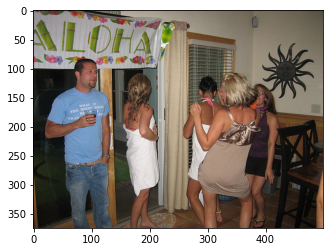

In [74]:
# Useful functions for images

def read_image(file_name):
    img_color = imageio.imread(file_name)
    return img_color

def display_image(img_in):
    if (img_in.ndim == 2):
        plt.imshow(img_in, cmap='gray')
    elif (img_in.ndim == 3):
        # careful, in this case we supppose the pixel values are between 0 and 255
        plt.imshow(np.uint8(img_in))
    else:
        print('Error, unknown number of dimensions in image')
    return

img = read_image(data_dir + files_image_analysis[0])
display_image(img)
img.shape

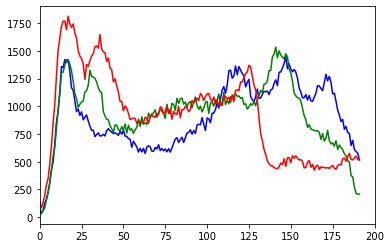

(576, 1)


In [75]:
# Test for the histogram for one image

color = ('b','g','r')
img_hist = []
for i,col in enumerate(color):
    histr = cv2.calcHist([img], [i], None, [192], [0,192])
    img_hist += histr.tolist() 
    plt.plot(histr,color = col)
    plt.xlim([0,200])
plt.show()

print(np.shape(img_hist))

As it is mentionned in the reasearch paper, we are going to do our colour clusterisation according to the RGB histogram of each images of the dataset we created above. 

To do so, we will compute the histogram of each colour channel of each images. We will consider a length of 192, the same as in the research paper, for each colour histogram. Then, we will concatenate the 3 histograms in order to have a single one. Thus, each image will be represented by a sequence of length $3 \times 192=576$.

The histogram that has been plotted above can be read as follows:
- each color represents a different channel: Red, Green and Blue (RGB);
- the values on the left represent darkness;
- the values on the right represent lightness;
- the y-axis is the proportion of pixels;

For example, on this histogram, we can see that the image has light and dark parts at the same time. The dark parts are mainly green and red (and, indeed, the sofa is dark red). The light parts are mainly white (because all of the three channels are involved and have a peak on the right). In the medium colors, there is a lot of blue (and we can see on the image that there are blue pictures in the back and a blue sheet on the sofa). 

<font color=darkred>Creation of the dataset that will be given to the model</font>

In [76]:
# Concatenation of the 3 histograms (RGB) of each image of the dataset into one single array
# The length will be the sum of the length of each histogram
# Warning: this cell can take a while to be executed

dataset = []
for file_name in files_image_analysis:
    img = read_image(data_dir + file_name)
    img_hist = []
    for i in range(3):
        histr = cv2.calcHist([img], [i], None, [192], [0,192])
        img_hist += (histr.reshape(-1,1)).tolist()
    dataset.append(img_hist)

In [77]:
print(np.array(dataset)[:,:,0].shape)

(10000, 576)


In [78]:
K = 30 # number of clusters
dim = 576
dataset = np.array(dataset)[:,:,0]

phi_init = np.random.dirichlet([np.random.random() * np.random.randint(1, 10)] * K, nb_dataset)
m_init = np.random.normal(0, 10, (K, dim))
s2_init = np.random.normal(0, 10, (K, dim, dim))
sigma2_init = np.identity(dim)
print(phi_init.shape)
print(s2_init.shape)
print(m_init.shape)
print(sigma2_init.shape)

(10000, 30)
(30, 576, 576)
(30, 576)
(576, 576)


Wall time: 1min 35s


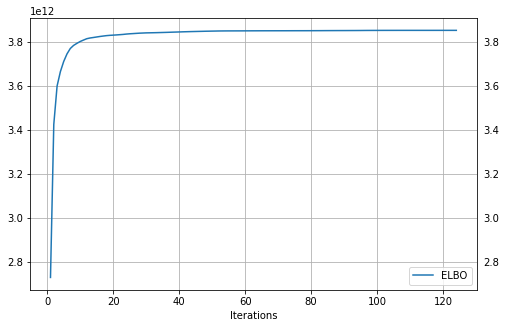

In [79]:
fig = plt.figure(figsize=(8,5))
%time elbos, m_est, s2_est, phi_est = CAVI_mixture_Gaussian(dataset, m_init, s2_init, phi_init, sigma2_init)
plt.plot(np.array(elbos), label = 'ELBO')
plt.tick_params(labelright=True)
plt.grid(True)
plt.xlabel('Iterations')
plt.legend();

In [80]:
print(elbos)

[nan, 2731213512057.6045, 3425961393116.8003, 3600225381451.7983, 3665527212729.7915, 3711439059476.5806, 3745897852386.7295, 3770473685428.8237, 3784537978546.3613, 3793842607912.716, 3802266757269.9395, 3808781386725.5737, 3814983720433.4844, 3818242870073.3506, 3820475209656.7305, 3822795298269.9556, 3825117502804.8833, 3827083124978.636, 3828960668541.894, 3830232140096.68, 3831164815733.6094, 3832148610034.8667, 3833249106822.246, 3834439307208.0327, 3836045193561.012, 3837283356846.802, 3838190924818.019, 3839180968124.6377, 3840113734568.3804, 3840761227639.255, 3841425900099.1113, 3841726667414.421, 3842055306695.965, 3842396321965.209, 3842815429570.08, 3843227848161.8438, 3843669126514.172, 3844148215044.077, 3844674695911.0454, 3845140113222.872, 3845638164396.397, 3846170935578.504, 3846616195349.237, 3847034604909.3516, 3847438588771.9756, 3847790042614.226, 3848148305537.5317, 3848478053933.818, 3848881667558.4453, 3849151807798.9033, 3849450777176.1963, 3849732072095.735

In [81]:
# Get the cluster of each image

list_clusterisation = phi_est[-1].argmax(axis=1)   
print(list_clusterisation)

[ 9 24 16 ... 16 26  3]


In [82]:
# Storage of each image in its cluster

list_cluster_image = [[] for k in range(K)]

for idx, cluster in enumerate(list_clusterisation) :
    list_cluster_image[cluster].append(files_image_analysis[idx])

print(list_cluster_image)

[['3351596152.jpg', '2782247529.jpg', '2429243285.jpg', '2309860995.jpg', '3385246141.jpg', '28041138.jpg', '3977104006.jpg', '6841943688.jpg', '2430269210.jpg', '3301741597.jpg', '4863999220.jpg', '4900546628.jpg', '6502488897.jpg', '3704709223.jpg', '3348385580.jpg', '3723690961.jpg', '2322797357.jpg', '3667908724.jpg', '4406996649.jpg', '2540757246.jpg', '1468741099.jpg', '2429305809.jpg', '3218889785.jpg', '4687354574.jpg', '3677613006.jpg', '3119174449.jpg', '3604881301.jpg', '289742991.jpg', '19366040.jpg', '2993049054.jpg', '2409771090.jpg', '5757492662.jpg', '565490650.jpg', '5593628279.jpg', '3091013719.jpg', '6977672552.jpg', '174984835.jpg', '5846691766.jpg', '7234519202.jpg', '3389995545.jpg', '2367317953.jpg', '2513740120.jpg', '6502487823.jpg', '4060562740.jpg', '4828858763.jpg', '4544881698.jpg', '2346523971.jpg', '7773991560.jpg', '2555545571.jpg', '2811918074.jpg', '4031513473.jpg', '3442242092.jpg', '2914022011.jpg', '4094966503.jpg', '6914075994.jpg', '2900271867.jpg

In [83]:
# We check the population of each cluster

for k in range(K):
    print(len(list_cluster_image[k]))

123
650
3
375
46
472
572
218
458
1577
212
0
0
0
324
1
1281
56
668
0
331
103
38
385
137
160
498
919
76
317


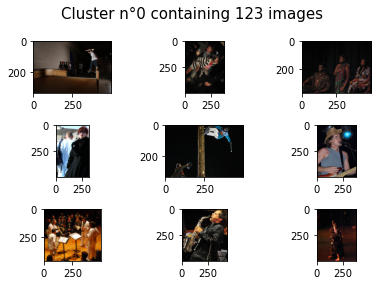

<Figure size 1080x288 with 0 Axes>

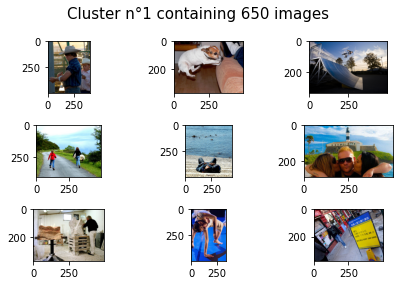

<Figure size 1080x288 with 0 Axes>

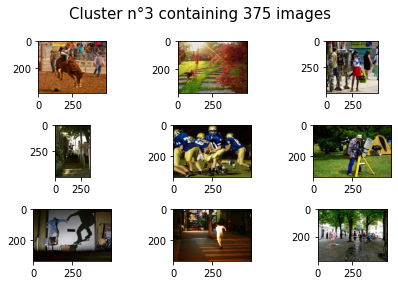

<Figure size 1080x288 with 0 Axes>

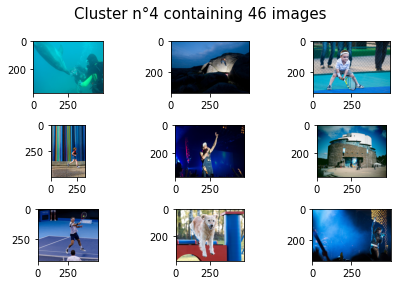

<Figure size 1080x288 with 0 Axes>

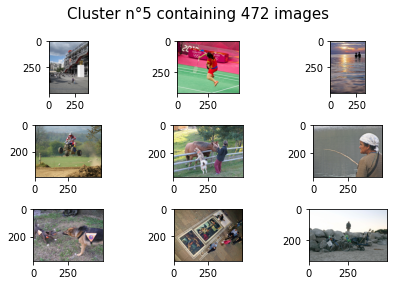

<Figure size 1080x288 with 0 Axes>

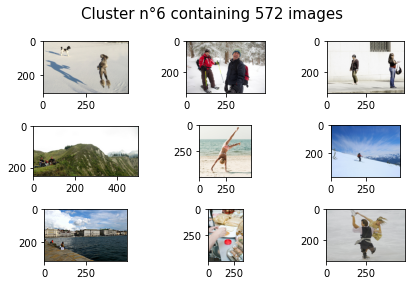

<Figure size 1080x288 with 0 Axes>

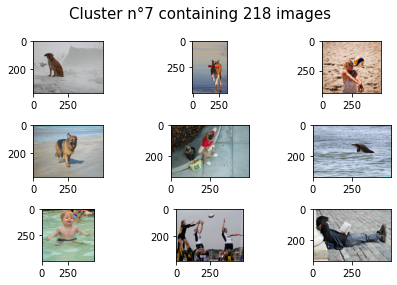

<Figure size 1080x288 with 0 Axes>

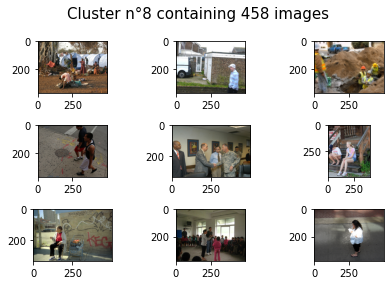

<Figure size 1080x288 with 0 Axes>

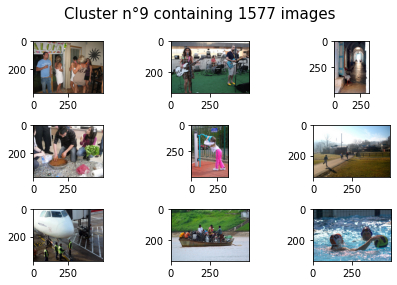

<Figure size 1080x288 with 0 Axes>

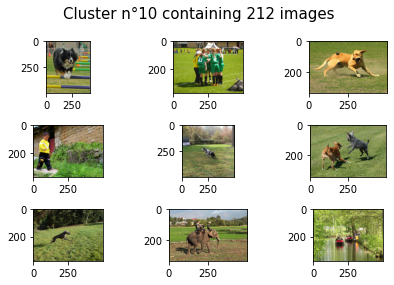

<Figure size 1080x288 with 0 Axes>

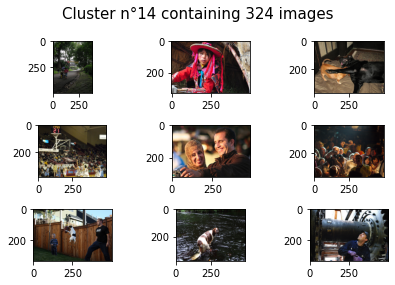

<Figure size 1080x288 with 0 Axes>

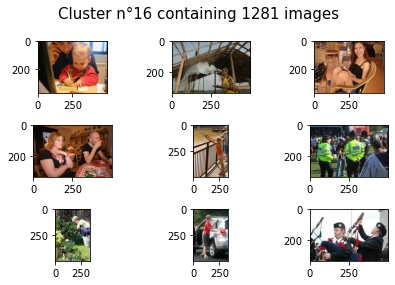

<Figure size 1080x288 with 0 Axes>

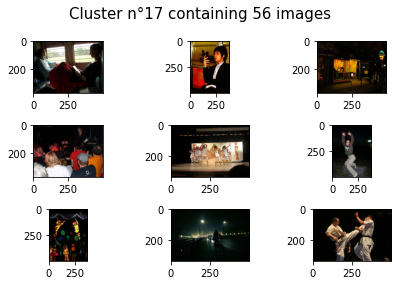

<Figure size 1080x288 with 0 Axes>

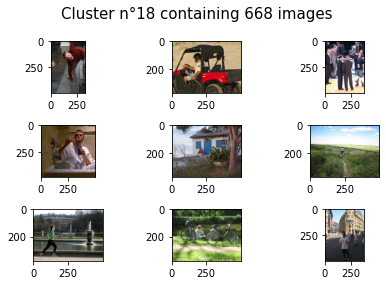

<Figure size 1080x288 with 0 Axes>

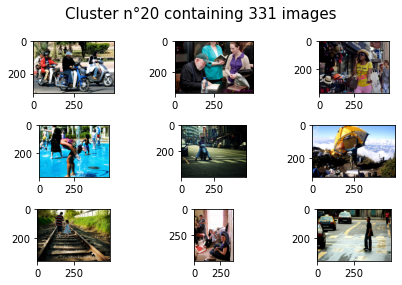

<Figure size 1080x288 with 0 Axes>

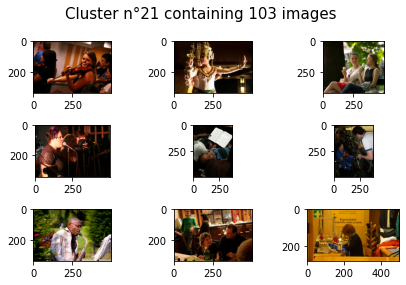

<Figure size 1080x288 with 0 Axes>

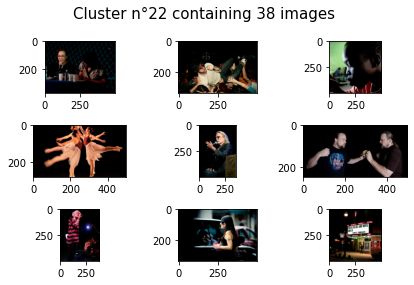

<Figure size 1080x288 with 0 Axes>

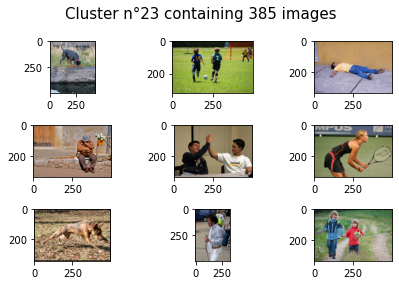

<Figure size 1080x288 with 0 Axes>

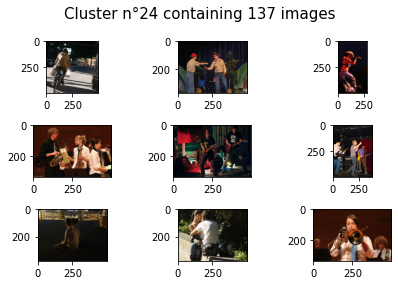

<Figure size 1080x288 with 0 Axes>

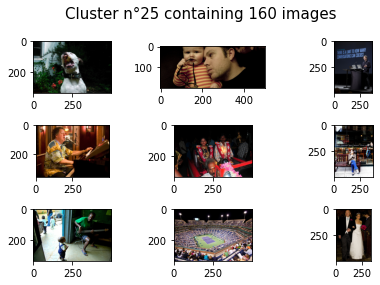

<Figure size 1080x288 with 0 Axes>

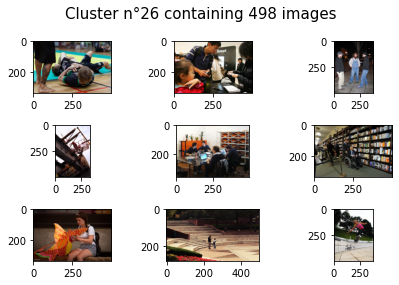

<Figure size 1080x288 with 0 Axes>

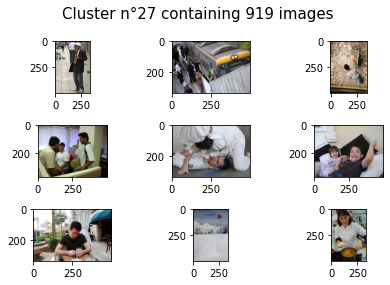

<Figure size 1080x288 with 0 Axes>

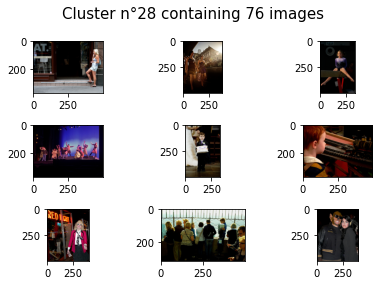

<Figure size 1080x288 with 0 Axes>

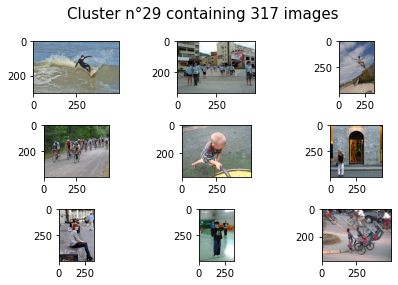

<Figure size 1080x288 with 0 Axes>

In [84]:
# Plot of 9 images of each cluster

for k in range(K):
    cluster = list_cluster_image[k]
    
    if len(cluster) >= 9 :
        f, axarr = plt.subplots(3,3)
        plt.figure(figsize=(15.0, 4.0))

        axarr[0,0].imshow(read_image(data_dir + cluster[0]))
        axarr[0,1].imshow(read_image(data_dir + cluster[1]))
        axarr[0,2].imshow(read_image(data_dir + cluster[2]))
        axarr[1,0].imshow(read_image(data_dir + cluster[3]))
        axarr[1,1].imshow(read_image(data_dir + cluster[4]))
        axarr[1,2].imshow(read_image(data_dir + cluster[5]))
        axarr[2,0].imshow(read_image(data_dir + cluster[6]))
        axarr[2,1].imshow(read_image(data_dir + cluster[7]))
        axarr[2,2].imshow(read_image(data_dir + cluster[8]))
        
        f.suptitle("Cluster n°" + str(k) + " containing " + str(len(cluster)) + " images", fontsize=15)
        
        f.tight_layout()

As we can see, each cluster contains images that have similar colours. For example, some clusters have blue images, others have images combining dark and light colors. In the first case, we expect the histograms to have high values (mostly in the center) of the blue channel and, in the second case, to have a U shape in each channel because darkness is represented by high values on the left of the histogram and lightness by high values on the right of the histogram. Let's check the histograms for each cluster.

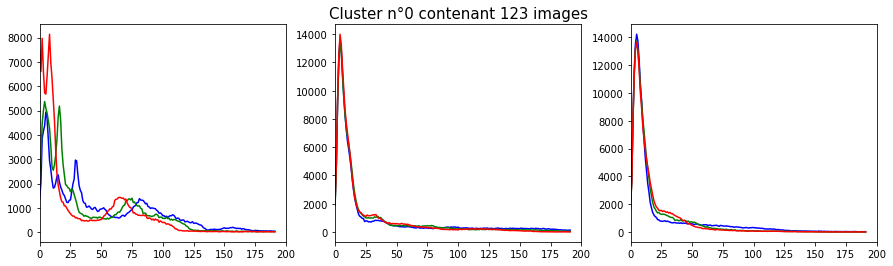

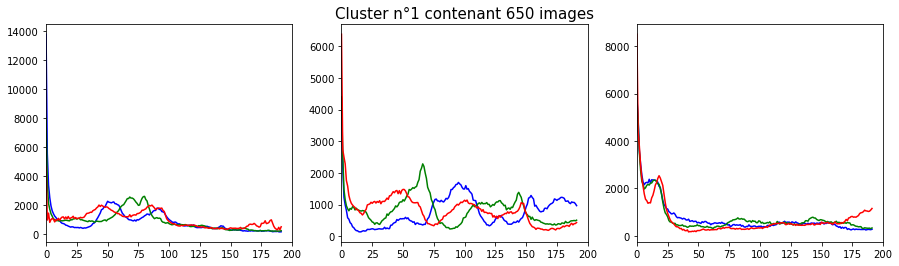

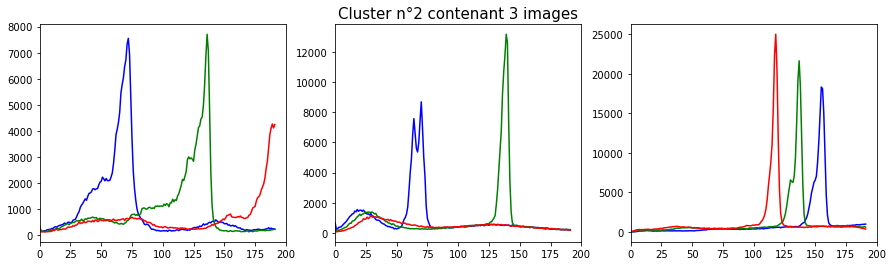

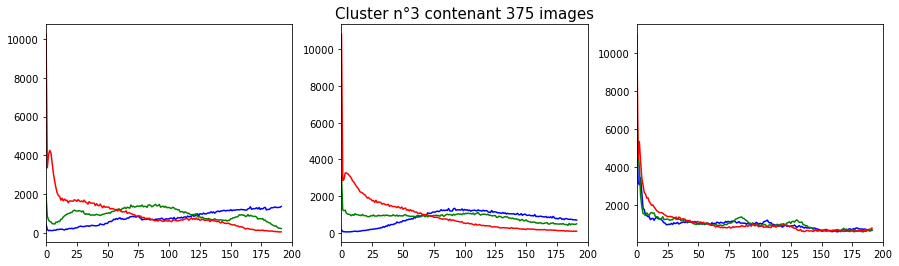

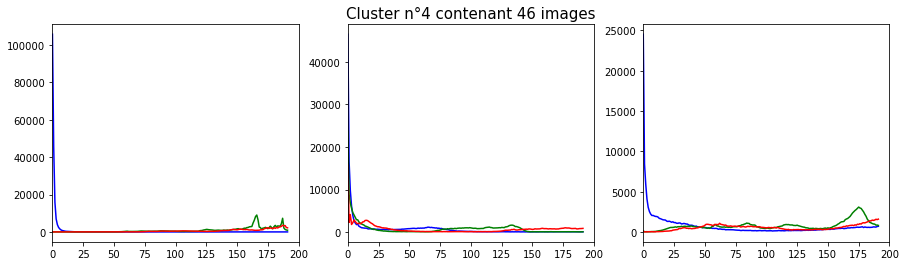

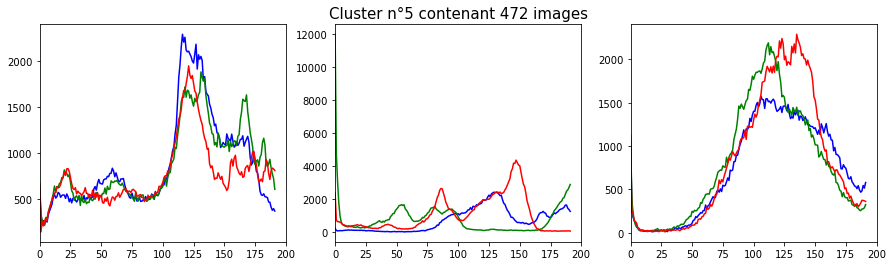

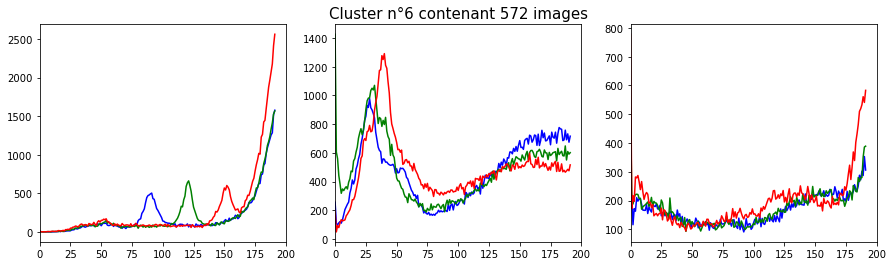

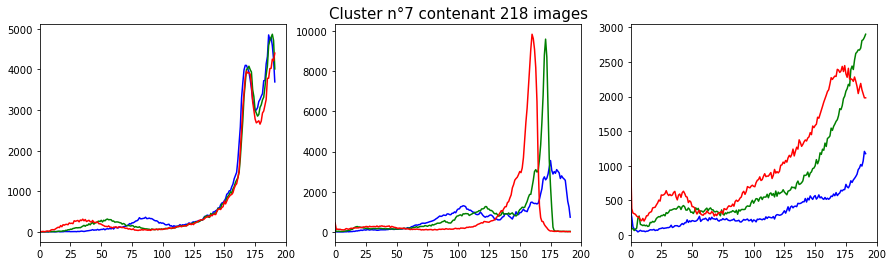

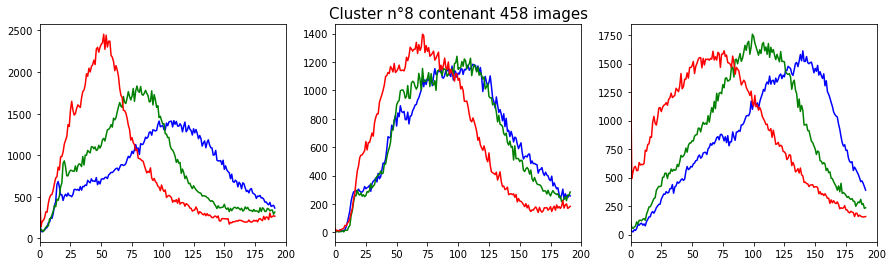

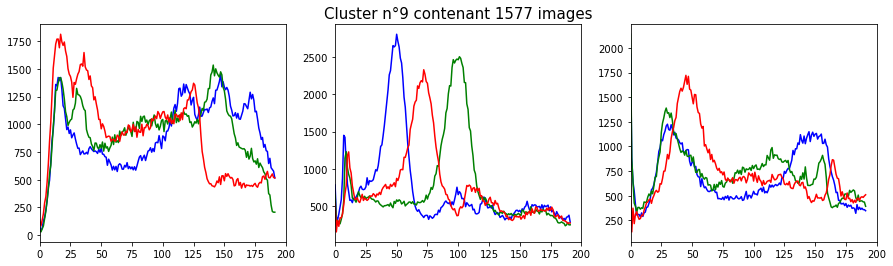

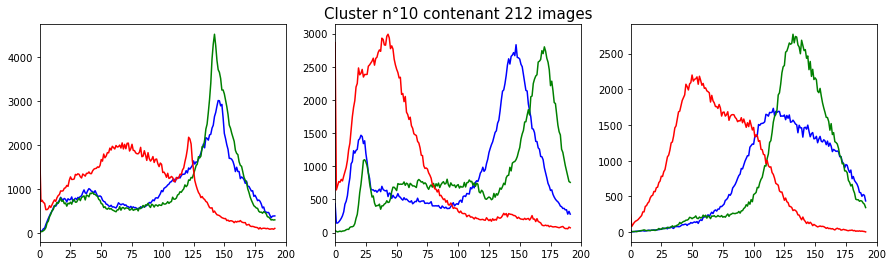

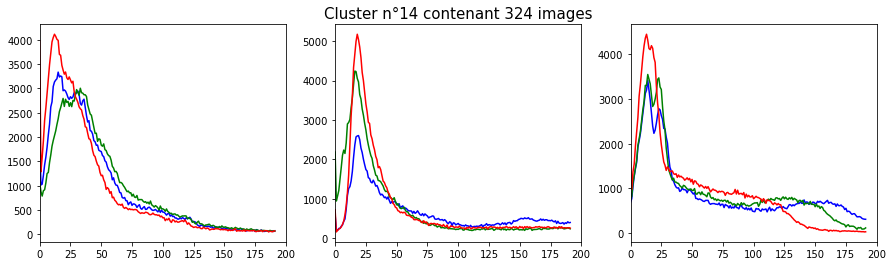

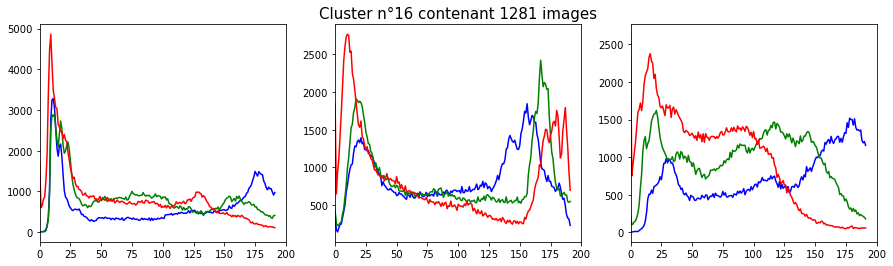

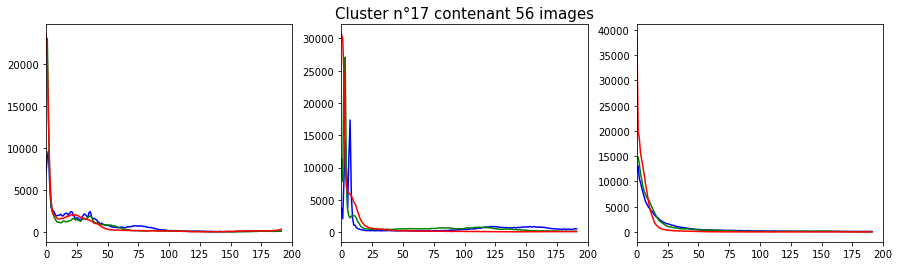

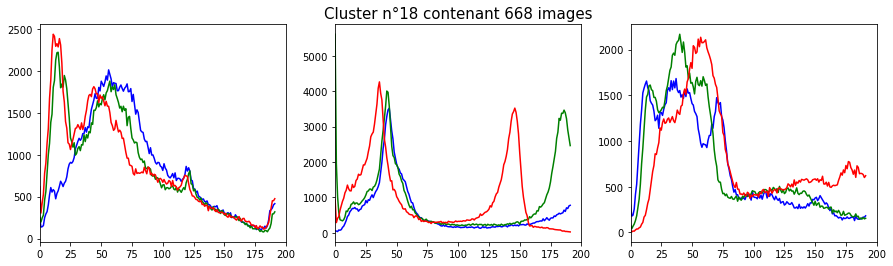

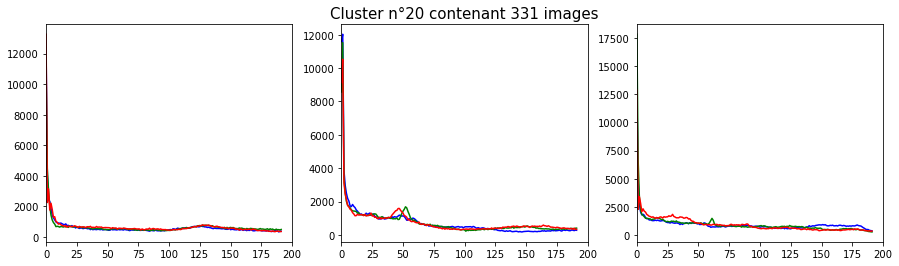

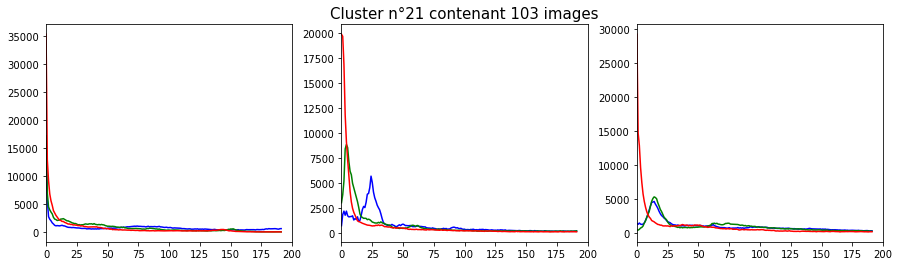

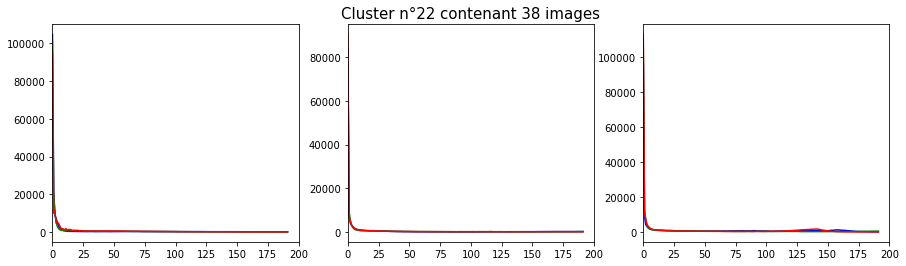

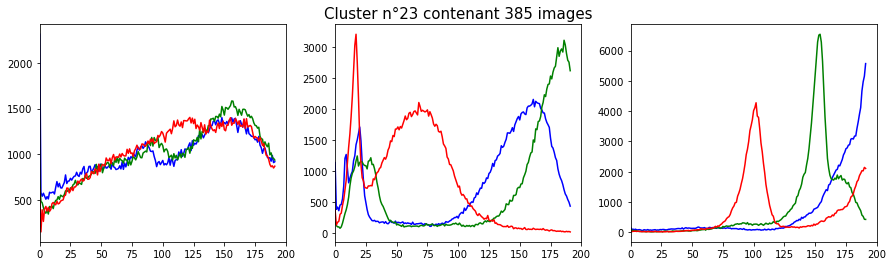

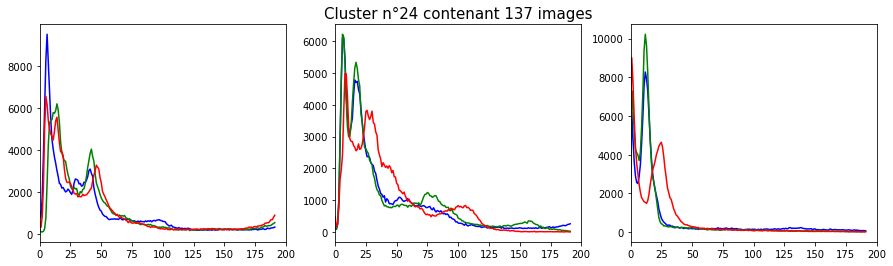

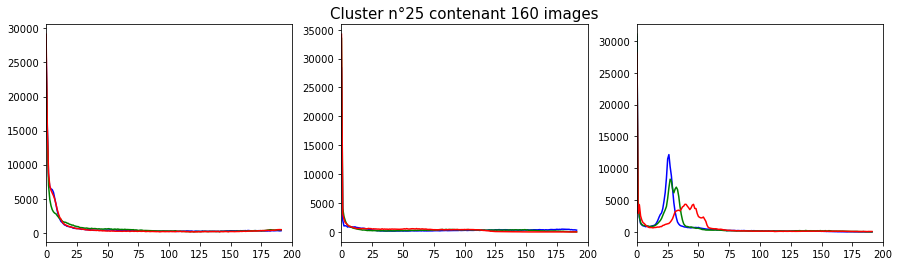

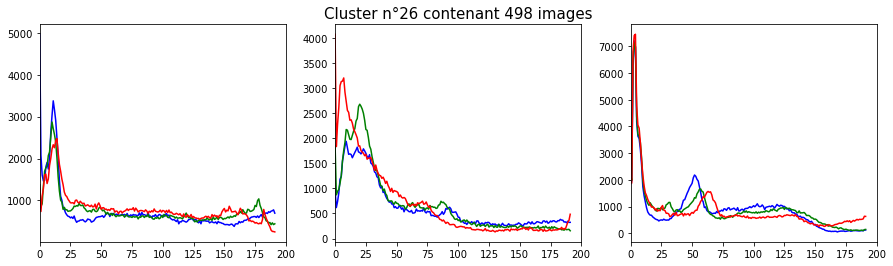

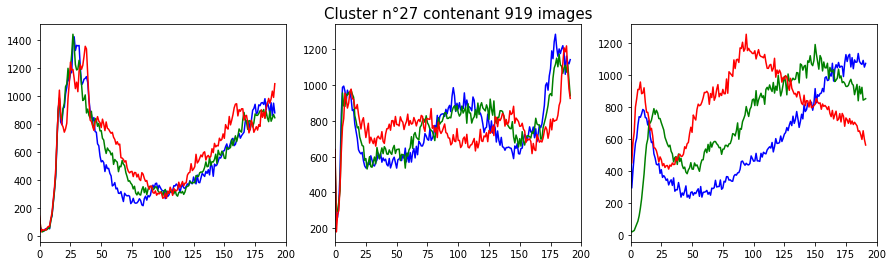

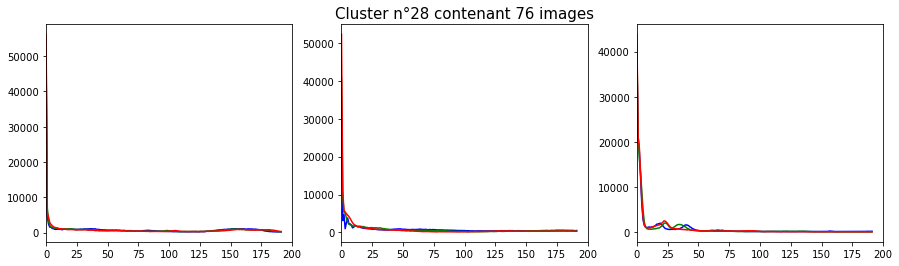

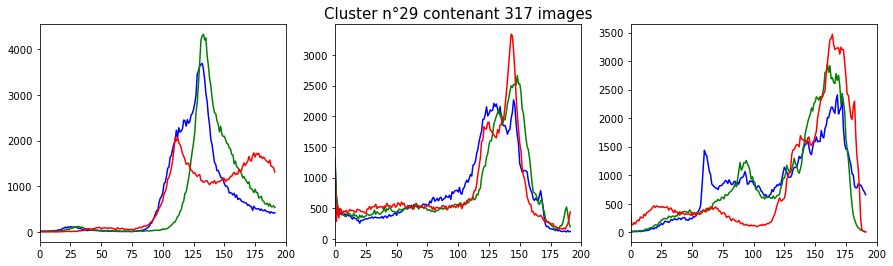

In [85]:
# Plot of the histogram of an image in each cluster

color = ('b','g','r')

for k in range(K):
    cluster = list_cluster_image[k]
    
    if len(cluster) >= 3:
        plt.figure(figsize=(15.0, 4.0))
        
        plt.subplot(1,3,1)
        for i, col in enumerate(color):
            histr = cv2.calcHist([read_image(data_dir + cluster[0])], [i], None, [192], [0,192])
            plt.plot(histr, color = col)
            plt.xlim([0,200])
        
        plt.subplot(1,3,2)
        for i, col in enumerate(color):
            histr = cv2.calcHist([read_image(data_dir + cluster[1])], [i], None, [192], [0,192])
            plt.plot(histr, color = col)
            plt.xlim([0,200])
        plt.title("Cluster n°" + str(k) + " contenant " + str(len(cluster)) + " images", fontsize=15)
            
        plt.subplot(1,3,3)
        for i, col in enumerate(color):
            histr = cv2.calcHist([read_image(data_dir + cluster[2])], [i], None, [192], [0,192])
            plt.plot(histr, color = col)
            plt.xlim([0,200])

We can see that the clusterisation is great because the histograms in each cluster are quite similar.